# Text Classification For Serbian Science Journals
<p>
The goal of this project is to see how different text classification algorithms classify text paragraphs of articles from Serbian scientific journals.


The data used for this project was made using an online archive of published Serbian scientific journals called 'Srpski Citatni Indeks', link of the site:
https://scindeks.ceon.rs/  
Data contains 1700 paragraphs that are split into 9 categories. These are the following categories: 
   - Architecture and construction engineering
   - Biology
   - Economy
   - Geoscience
   - Chemistry
   - Informatics and electrical engineering
   - Mathematics
   - Medicine
   - Agriculture

   
Each paragraph is also labeled whether it is written in Serbian or English. Due to the nature of Serbian scientific community, there are more scientific works in English language as they are more available to the international community. Some categories have only scientific works that are written in English, as there are minimal to none written in Serbian. Here is the ratio of Serbian to English paragraphs 
for each category:
   - Architecture and construction engineering - Serbian ~48%, English ~52%
   - Biology - Serbian ~39%, English 71%
   - Economy - Serbian ~45%, English ~55%
   - Geoscience - Serbian ~30%, English ~%70
   - Chemistry - Serbian 0%, English 100%
   - Informatics and electrical engineering - Serbian ~3%, English ~97%
   - Mathematics - Serbian 0%, Englsih 100%
   - Medicine - Serbian ~52%, English ~48%
   - Agriculture - Serbian ~51%, English 49%


Algorithms that are used in this project are: Multionomial Naive Bayes, K-Nearest Neighbours and Support Vector Machine. Besides them there are two vectorizers on which the algorithms are tested on: CountVectorizer and TfidfVectorizer

Libraries that are included in this project are: Skicit-Learn, Pandas, Numpy, MatplotLib, NLTK and a Serbian library for NLP, SrbAi

Metrics for evaluation are Skicit-Learns Accuracy and Macro Average metrics.

The data is split 70% into test data, 15% into validation data, 15% into test data
</p>




In [1]:
import re
import pandas as pd
import numpy as np
from srbai.SintaktickiOperatori import spellcheck
from srbai.SintaktickiOperatori.stemmer_nm import stem_str, stem_arr
from srbai.JezickiModeli import FastText
from sklearn.naive_bayes import MultinomialNB
import csv
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<p>We load the csv file content, define its delimiter, and rewrite it into a new csv file, with lineterminators accurately representing end of each row</p>

In [2]:
custom_dialect = csv.excel()
custom_dialect.delimiter = '»'

file_path = 'data/serbian_science_journals_dataset.csv'

with open(file_path, 'r', encoding="utf-8") as file:
    file_content = file.read()

In [3]:

file_content = file_content.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
file_content = file_content.replace('«', '\n')

#Correcting labels in case there were issues with overwriting
file_content =file_content.replace(r" Economy»", "Economy»").replace(r" IE»", "IE»").replace(r" Medicine»", "Medicine»").replace(r" Agriculture»", "Agriculture»").replace(r" AC»", "AC»").replace(r" Geoscience»", "Geoscience»").replace(r" Chemistry»", "Chemistry»").replace(r" Mathematics»", "Mathematics»").replace(r" Biology»", "Biology»")

with open('data/serbian_science_journals_dataset_modified.csv', 'w', encoding="utf-8") as file:
    file.write(file_content)

file_path = 'data/serbian_science_journals_dataset_modified.csv'

In [4]:
with open(file_path, 'r', newline='', encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file, dialect=custom_dialect)
    data = list(reader)

df = pd.DataFrame(data)

# Preprocessing

<p>We filter through insufficient characters in our data</p>

In [5]:
pattern = r"[/&|!,:;()\@.#\'\"\[\]{}+\^*/=\$_–—%€°™©><`~0-9-]"
df = df.replace(pattern, ' ', regex=True)
df = df.replace(r"[?]", 'cy', regex=True)

pattern = r"[\r\n\t\u000a\u000b\u000c\u000d\u0085\u2028\u2029\u00a0\u1680\u2000\u2001\u2002\u2003\u2004\u2005\u2006\u2007\u2008\u2009\u200a\u202f\u205f\n\u3000\r]"
df = df.replace(pattern, ' ', regex=True)

<p>We define our collections per column, one for languages, one for categories, and one where our paragraphs are stored</p>

In [6]:
column_length = len(df[1])
df_language_collection = [[] for _ in range(column_length)]
df_label_collection = [[] for _ in range(column_length)]
df_token_collection = [[] for _ in range(column_length)]

for idx, language in enumerate(df[2]):
    df_language_collection[idx] = language

for idx, label in enumerate(df[0]):
    df_label_collection[idx] = label

for idx, text_paragraph in enumerate(df[1]):
    text_paragraph = text_paragraph.lower()
    df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)


<p>We iterate through the collection of tokens, each according to their language label, if the token is in Serbian we use SrbAi's Stemming and stop words from their package as well as some custom additional words of ours. If the token is in English we use NLTK's WordNetLemmatizer and also add some custom additional stop words according to our projects needs</p>

In [7]:
#CONTENT OF 'serbian_stopwords.txt' FILE IS COPIED FROM SRBAI serbian_stopwords.txt FILE
file_path = 'stop_words/serbian_stopwords.txt'

with open(file_path, 'r', newline='', encoding='utf-8') as file:
    data = file.read()

serbian_stop_words = data.split(',')
english_stop_words = stopwords.words()

if(serbian_stop_words.__contains__('jesam') or serbian_stop_words.__contains__('ali') or serbian_stop_words.__contains__('ili') or
   serbian_stop_words.__contains__('slika') or serbian_stop_words.__contains__('tabela') or serbian_stop_words.__contains__('tab')):
    serbian_stop_words.append('jesam','ali','ili','slika','tabela','tab')


if(english_stop_words.__contains__('table') or english_stop_words.__contains__('image') or english_stop_words.__contains__('figure') or
   english_stop_words.__contains__('fig')):
    english_stop_words.append('table', 'image', 'figure', 'fig')



In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer()

for idx, text_paragraph in enumerate(df[1]):

    if df_language_collection[idx] == 'Serbian':
        df_token_collection[idx] = stem_arr(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in serbian_stop_words]
        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]

        #print("Serbian")
        #print(df_token_collection[idx])
    else:
        df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]
        for idx_token, _ in enumerate(df_token_collection[idx]):
            df_token_collection[idx][idx_token] = lemmatizer.lemmatize(df_token_collection[idx][idx_token])
            df_token_collection[idx][idx_token] = df_token_collection[idx][idx_token].lower()

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]

        #print("English")
        #print(df_token_collection[idx])


# Vectorizers

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


In [10]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()
classifier = MultinomialNB()
label_encoder = LabelEncoder()

<p>We conjoin our tokens into a document string</p>

In [11]:
df_x = [[] for _ in range(column_length)]
for idx, _ in enumerate(df_x):
    df_x[idx] = " ".join(df_token_collection[idx])

df_x_documents = [' '.join(tokens) for tokens in df_token_collection]

<p>Our random seed</p>

In [12]:
random_state_seed = 42

<p>We fit and transform our data to the vectors, and encode our categories in y</p>

In [13]:
X = [[] for _ in range(column_length)]
y = [[] for _ in range(column_length)]

X = countVectorizer.fit_transform(df_x_documents)
y = label_encoder.fit_transform(df_label_collection)

X_tf = tfidfVectorizer.fit_transform(df_x_documents)

<p>Size of our vocabulary</p>

In [14]:
print("Vocabulary size:")
print(len(countVectorizer.vocabulary_))

Vocabulary size:
37387


# Validation Data

<p>We split our data into train, test and validation data with the holdout method</p>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

In [16]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1765, random_state=random_state_seed)

X_train_tf, X_validate_tf, y_train_tf, y_validate_tf = train_test_split(X_train_tf, y_train_tf, test_size=0.1765, random_state=random_state_seed)

<p>We fit and predict our data according to our classifier, then we represent how accurate the predictions are with Accuracy and Macro Average metric scores, and with confusion matrix visually as well. We test our algorithm on both CountVectorizer, as well as TfidfVectorizer</p>

<p>Multinomial Naive Bayes with Count Vectorizer </p>

Accuracy score: 
0.8117647058823529
Macro Average score: 
0.8277294106877375


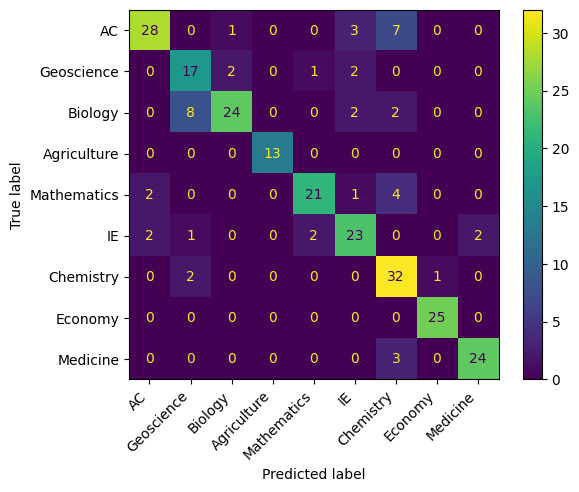

In [17]:
multinomialnb_classifier = MultinomialNB()

multinomialnb_classifier.fit(X_train, y_train)

y_pred = multinomialnb_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes with TF-IDF Vectorizer </p>

Accuracy score: 
0.7607843137254902
Macro Average score: 
0.7720447327920607


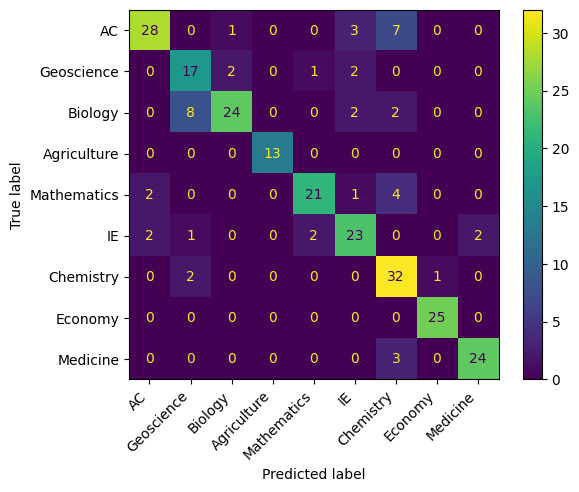

In [18]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(X_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

In [19]:
from sklearn.neighbors import KNeighborsClassifier


<p>K-Nearest Neighbors with Count Vectorizer </p>

Accuracy score: 
0.2
Macro Average score: 
0.18868162966450067


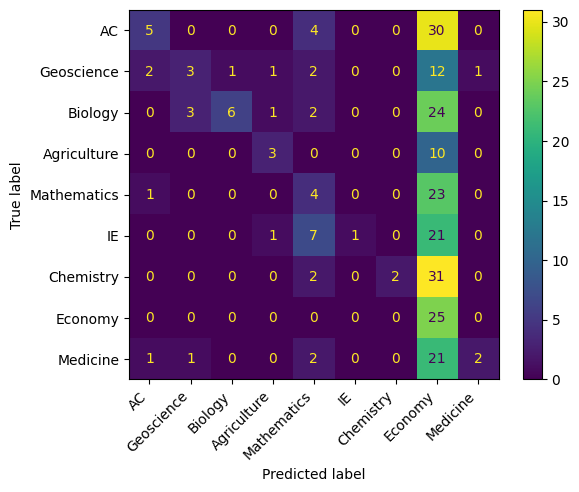

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>K-Nearest Neighbors with TF-IDF Vectorizer </p>

Accuracy score: 
0.8117647058823529
Macro Average score: 
0.8206234067519994


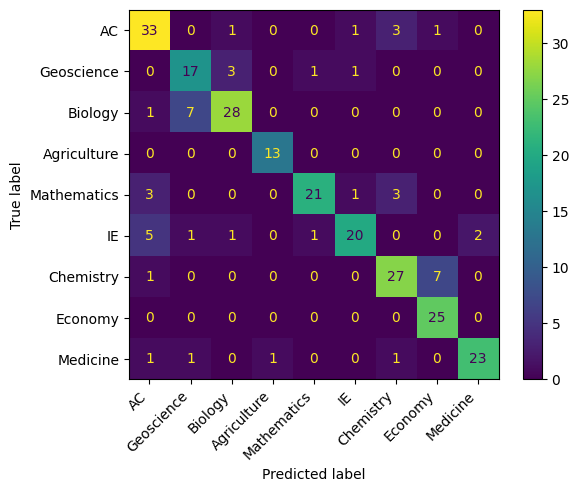

In [21]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(X_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()



In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

<p>Support Vector Machine with Counter Vectorizer </p>

Accuracy score: 
0.6392156862745098
Macro Average score: 
0.6394596878879111


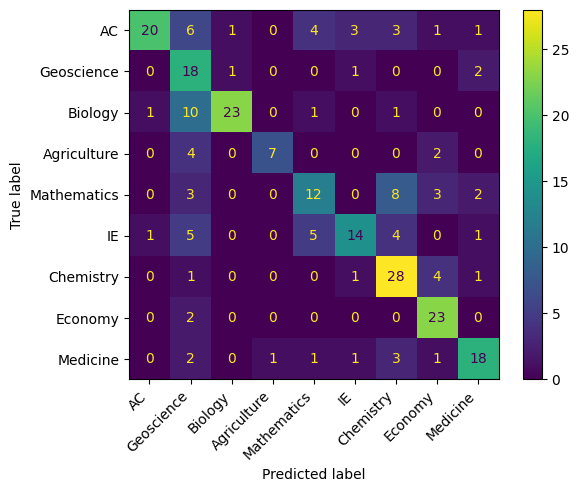

In [23]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.796078431372549
Macro Average score: 
0.8042917921453288


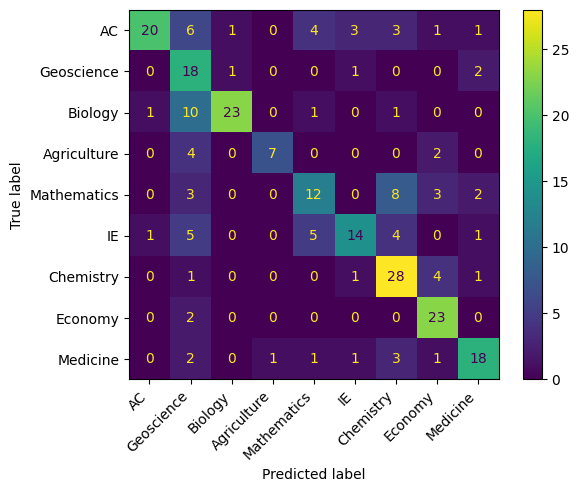

In [24]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(X_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

# Test Data

<p>Now we test our data on fine-tuned variations of our algorithms</p>

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV


<p>We split our data into train and test data, according to the random seed</p>

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

# X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

<p>Multinomial Naive Bayes Count Vectorizer </p>

Accuracy score: 
0.8392156862745098
Macro Average score: 
0.8368899985878822


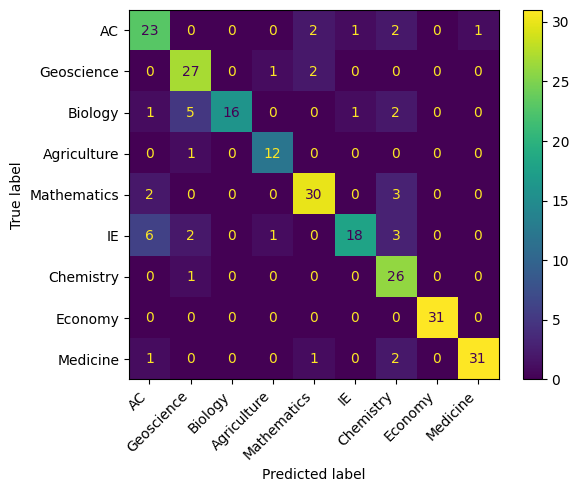

In [27]:

multinomialnb_classifier = MultinomialNB(alpha=1)
multinomialnb_classifier.fit(X_train, y_train)


y_pred = multinomialnb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                              'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes TF-IDF Vectorizer </p>

Accuracy score: 
0.8117647058823529
Macro Average score: 
0.8042609810336157


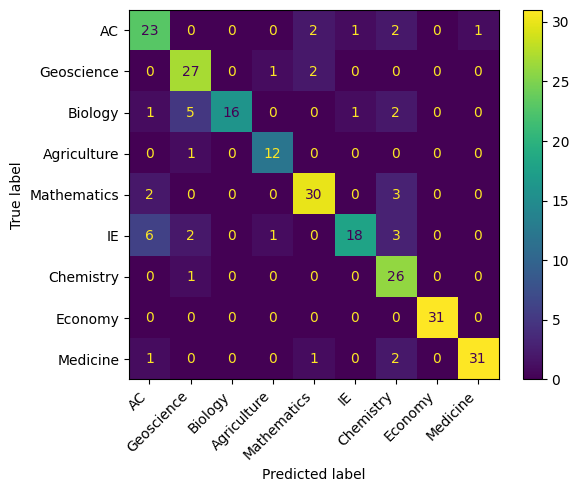

In [28]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(X_test_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Imporved K-Nearest Neighbor with Count Vectorizer </p>

Accuracy score: 
0.3803921568627451
Macro Average score: 
0.3910958967650961


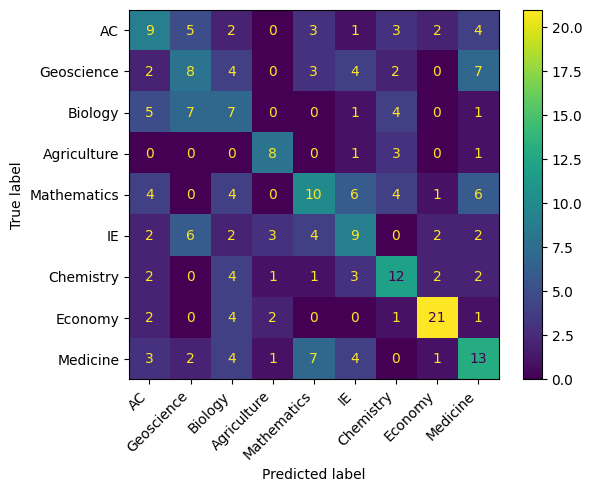

In [29]:
from sklearn.neighbors import KNeighborsTransformer

knn_transformer = KNeighborsTransformer(n_neighbors=9)
knn_classifier = KNeighborsClassifier(weights='distance')

knn_pipeline = make_pipeline(knn_transformer, knn_classifier)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved K-Nearest Neighbor with TF-IDF Vectorizer </p>

Accuracy score: 
0.8196078431372549
Macro Average score: 
0.8239331082595348


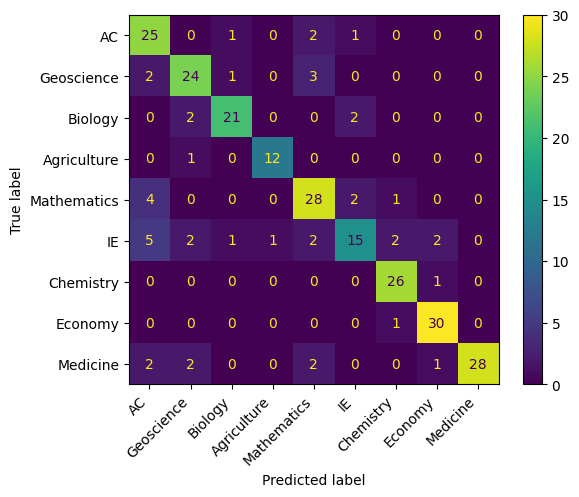

In [30]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(X_test_tf)


accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with Count Vectorizer </p>

Accuracy score: 
0.7764705882352941
Macro Average score: 
0.7762913801544834


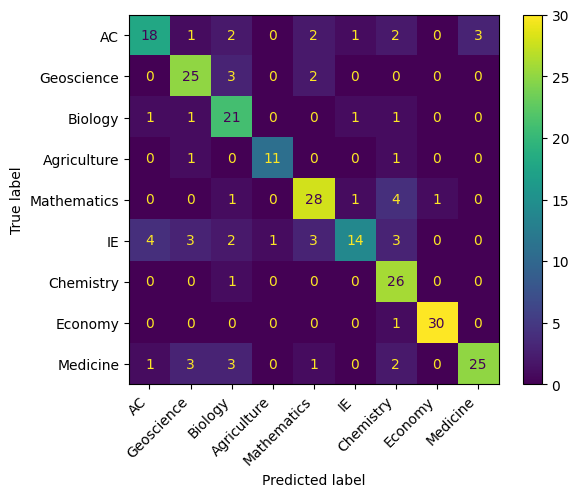

In [31]:

svc_classifier = SVC(kernel='sigmoid')


svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.8666666666666667
Macro Average score: 
0.866812986722565


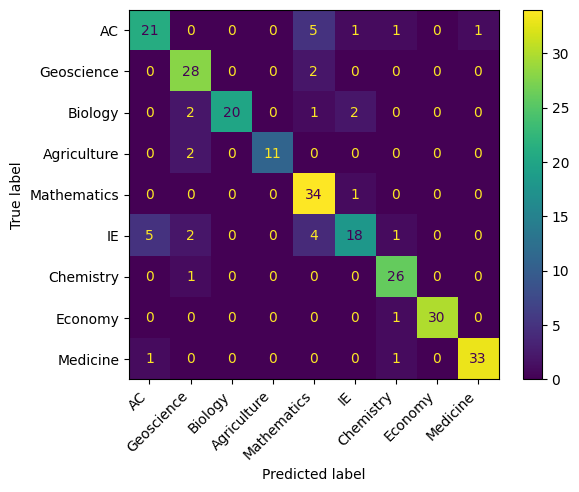

In [32]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(X_test_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print( accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print( macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

# Addition to the Original Project: MLP Classifier

<p>Addition to the original project is testing the Skicit-Learns Multilayer Perceptron (MLP) Classifier. Here it is tested on both Count and TF-IDF vectorizers, with validation data, as well as with fine-tuned parameters for test data. Besides these two vectorizers, Word2Vec vectorization is also tested on this algorithm</p>

Results show MLPs great performances with Count and TF-IDF Vectorizers, while lower with Word2Vec, however still substantially better performance than if we were to use any other algoritm in our project with Word2Vec vectorization.

<p>Multilayer Perceptron with Count Vectorizer</p>

Iteration 1, loss = 1.95563039
Iteration 2, loss = 0.86960397
Iteration 3, loss = 0.32356829
Iteration 4, loss = 0.13211818
Iteration 5, loss = 0.06366830
Iteration 6, loss = 0.03661721
Iteration 7, loss = 0.02385479
Iteration 8, loss = 0.01722635
Iteration 9, loss = 0.01331483
Iteration 10, loss = 0.01094026
Iteration 11, loss = 0.00920225
Iteration 12, loss = 0.00799828
Iteration 13, loss = 0.00704689
Iteration 14, loss = 0.00628430
Iteration 15, loss = 0.00568253
Iteration 16, loss = 0.00517698
Iteration 17, loss = 0.00474648
Iteration 18, loss = 0.00438231
Iteration 19, loss = 0.00404166
Iteration 20, loss = 0.00375007
Iteration 21, loss = 0.00349611
Iteration 22, loss = 0.00327312
Iteration 23, loss = 0.00306086
Iteration 24, loss = 0.00288968
Iteration 25, loss = 0.00271654
Iteration 26, loss = 0.00257075
Iteration 27, loss = 0.00242933
Iteration 28, loss = 0.00230557
Iteration 29, loss = 0.00219433
Iteration 30, loss = 0.00208322
Iteration 31, loss = 0.00199266
Iteration 32, los

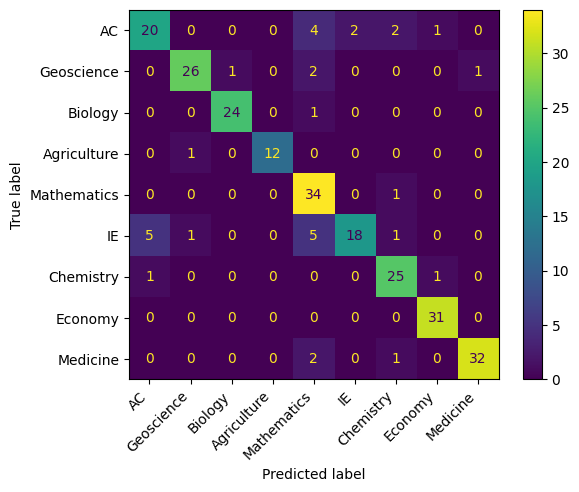

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=random_state_seed, verbose=True)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Improved Multilayer Perceptron with Count Vectorizer, with very minimal improvement</p>

Iteration 1, loss = 1.64607443
Iteration 2, loss = 0.29356058
Iteration 3, loss = 0.05794605
Iteration 4, loss = 0.02156540
Iteration 5, loss = 0.01222883
Iteration 6, loss = 0.00866900
Iteration 7, loss = 0.00673618
Iteration 8, loss = 0.00558111
Iteration 9, loss = 0.00474658
Iteration 10, loss = 0.00411616
Iteration 11, loss = 0.00365653
Iteration 12, loss = 0.00324085
Iteration 13, loss = 0.00290443
Iteration 14, loss = 0.00264563
Iteration 15, loss = 0.00244099
Iteration 16, loss = 0.00223622
Iteration 17, loss = 0.00207549
Iteration 18, loss = 0.00194263
Iteration 19, loss = 0.00182935
Iteration 20, loss = 0.00172824
Iteration 21, loss = 0.00163693
Iteration 22, loss = 0.00155477
Iteration 23, loss = 0.00148823
Iteration 24, loss = 0.00142536
Iteration 25, loss = 0.00136754
Iteration 26, loss = 0.00131678
Iteration 27, loss = 0.00127543
Iteration 28, loss = 0.00122988
Iteration 29, loss = 0.00119116
Iteration 30, loss = 0.00115659
Iteration 31, loss = 0.00112628
Training loss did

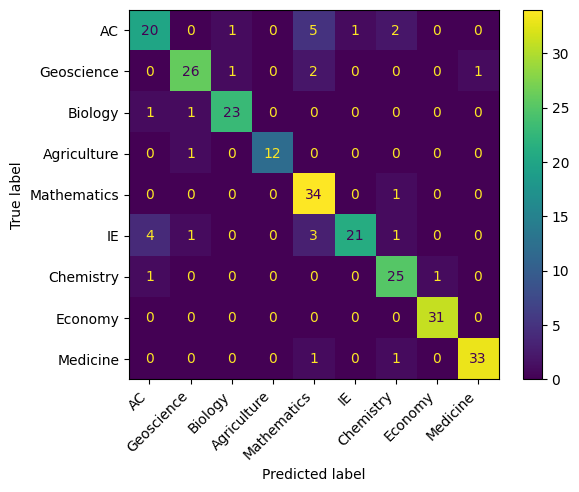

In [34]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), random_state=random_state_seed, alpha=0.0003, batch_size=100, learning_rate='adaptive',verbose=True,
                               n_iter_no_change=10, learning_rate_init=0.002, max_iter=1000)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Multilayer Perceptron with TF-IDF Vectorizer</p>

Iteration 1, loss = 2.19504221
Iteration 2, loss = 2.09725981
Iteration 3, loss = 1.97029405
Iteration 4, loss = 1.81955224
Iteration 5, loss = 1.65183800
Iteration 6, loss = 1.47474219
Iteration 7, loss = 1.29334173
Iteration 8, loss = 1.11318252
Iteration 9, loss = 0.94146026
Iteration 10, loss = 0.78324929
Iteration 11, loss = 0.64351967
Iteration 12, loss = 0.52418559
Iteration 13, loss = 0.42552183
Iteration 14, loss = 0.34590763
Iteration 15, loss = 0.28299136
Iteration 16, loss = 0.23336065
Iteration 17, loss = 0.19433571
Iteration 18, loss = 0.16413086
Iteration 19, loss = 0.13985972
Iteration 20, loss = 0.12049037
Iteration 21, loss = 0.10520291
Iteration 22, loss = 0.09258046
Iteration 23, loss = 0.08222090
Iteration 24, loss = 0.07367358
Iteration 25, loss = 0.06633730
Iteration 26, loss = 0.06022533
Iteration 27, loss = 0.05491110
Iteration 28, loss = 0.05037224
Iteration 29, loss = 0.04638642
Iteration 30, loss = 0.04292382
Iteration 31, loss = 0.03985797
Iteration 32, los

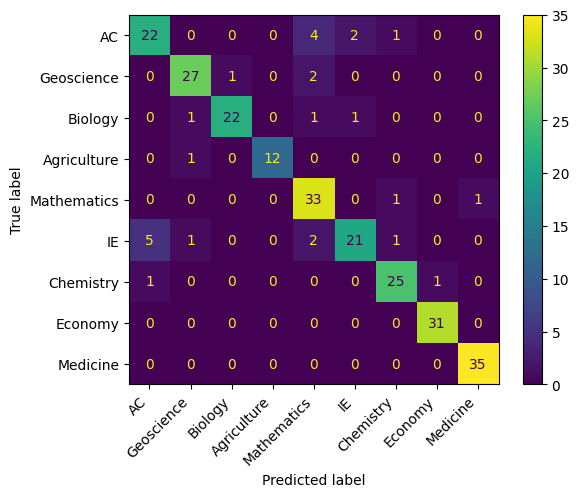

In [35]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=random_state_seed, verbose=True)
mlp_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = mlp_classifier.predict(X_test_tf)

accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test_tf, y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Modified Multilayer Perceptron with TF-IDF Vectorizer</p>

Iteration 1, loss = 2.01828362
Iteration 2, loss = 0.86017672
Iteration 3, loss = 0.14279957
Iteration 4, loss = 0.02040037
Iteration 5, loss = 0.01088205
Iteration 6, loss = 0.01101946
Iteration 7, loss = 0.01193192
Iteration 8, loss = 0.01268836
Iteration 9, loss = 0.01317618
Iteration 10, loss = 0.01343072
Iteration 11, loss = 0.01351277
Training loss did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Accuracy score: 0.8745098039215686
Macro Average score: 0.8771782330727027


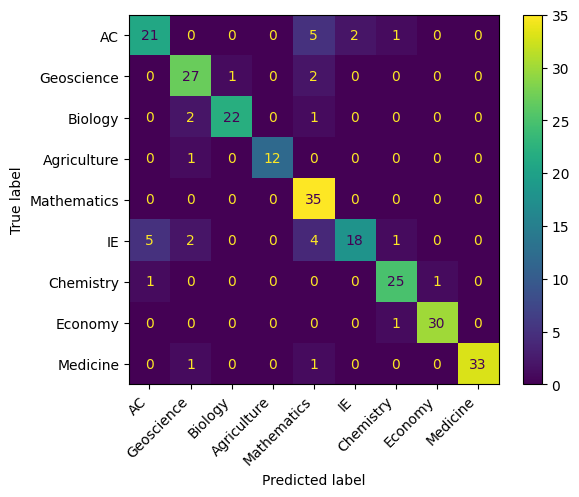

In [36]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(750,), random_state=random_state_seed, alpha=0.0003, batch_size=300, learning_rate='adaptive',verbose=True,
                               n_iter_no_change=5, learning_rate_init=0.005, max_iter=1000)
mlp_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = mlp_classifier.predict(X_test_tf)

accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test_tf, y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Creating new data for Word2Vec vectorizer, here we take per each paragraph a mean vector value of the words vector value in that paragraph for fitting. Due to the size of our data set we have to reduce its dimensionality, as well as to perform normalization of our vector values to non-negative.</p>

In [37]:
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA

X_train, X_validate, y_train, y_validate = train_test_split(df_x_documents, y, test_size=0.15, random_state=random_state_seed)

# Tokenize the training set
tokenized_docs = [doc.split() for doc in X_train]

# Train the Word2Vec model
word2vec_model = Word2Vec(tokenized_docs, vector_size=500, window=5, min_count=1, workers=4)

# Tokenize and convert the training set into feature vectors
X_train_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc if word in word2vec_model.wv], axis=0) for doc in tokenized_docs])


# Perform dimensionality reduction with PCA on X_train_w2v
num_dimensions = 200  # Choose the number of dimensions you want
pca = KernelPCA(n_components=num_dimensions)
X_train_w2v_reduced = pca.fit_transform(X_train_w2v)

# Normalize the feature vectors
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_w2v_normalized = scaler.fit_transform(X_train_w2v_reduced)

# Tokenize and convert the validation set into feature vectors
tokenized_docs_validate = [doc.split() for doc in X_validate]
X_validate_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc if word in word2vec_model.wv], axis=0) for doc in tokenized_docs_validate])
X_validate_w2v_reduced = pca.transform(X_validate_w2v)
X_validate_w2v_normalized = scaler.transform(X_validate_w2v_reduced)

<p>Multilayer Perceptron with Word2Vec, here we have also used grid search to find the best hyperparameters for our algorithm</p>

Accuracy: 0.6862745098039216
Macro-average F1 score: 0.6954333062023603


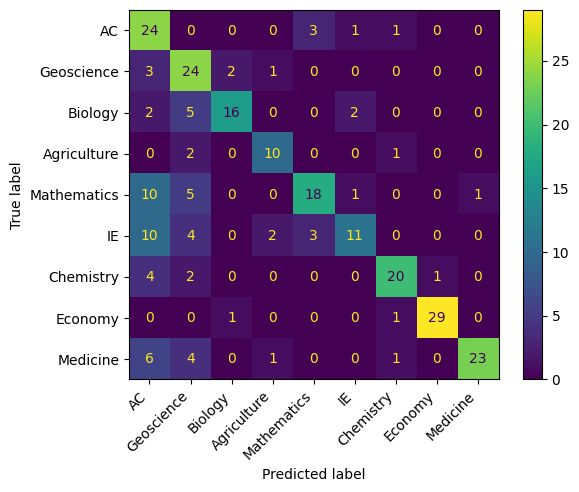

Best hyperparameters:
{'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}


In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

param_grid = {
    'hidden_layer_sizes': [(50,), (100), (200,)],
    'learning_rate_init': [0.001, 0.005, 0.01]
}

mlp_classifier = MLPClassifier(max_iter=1000, random_state=random_state_seed, verbose=False)

grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_w2v_normalized, y_train)

best_params = grid_search.best_params_
best_mlp_classifier = grid_search.best_estimator_

y_pred = best_mlp_classifier.predict(X_validate_w2v_normalized)

accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy:", accuracy)

macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro-average F1 score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_validate, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

print('Best hyperparameters:')
print(best_params)